In [3]:
##########################################       SET PARAMETERS      ######################################################

preindustrial_threshold = False
window                  = 101
percent                 = 10#   <-----  DEFINE EXTREME EVENT DEFINITION

#Monte Carlo simulation 
n_iterations            = 100000
window_montecarlo       = 100#  <------*13 if not accounting for autocorrelation
percent_montecarlo      = percent
auto_corr               = True
run                     = True

###########################################################################################################################
##########################################    AHA in LME running bin   ####################################################
###########################################################################################################################


print('AHA Diagnostic and Running Bin Analysis on CESM-LME ouput. Window is '+
      str(window)+
      '; analyzing largest '+
      str(percent)+
      '% of AHA events.')

threshold_lme = get_threshold(filename='//climodes/data3/datasets/ucar/cesm1-cam5-lme/psl/b.e11.BLMTRC5CN.f19_g16.001.cam.h0.PSL.*.nc',
                              var_name='PSL',
                              open_as_data_array=False,
                              fix_lon=True,
                              calculate_seasonal_average=True,
                              region=dict(lat_min = 10,
                                          lat_max = 52,
                                          lon_min = -60,
                                          lon_max = 10),
                              conversion=.01)

#Loading LME PSL data 
# EnsembleMembers_psl_DJF = np.load('/data/ncresswell/cesm-cam5-lme/EnsembleMembers_DJF_SLP_850-2005.npy')
# EnsembleMembers_psl_DJF = np.load('/data/ncresswell/cesm-cam5-lme/DETRENDED-NA_EnsembleMembers_DJF_SLP_850-2005.npy')
# EnsembleMembers_psl_DJF = np.load('/data/ncresswell/cesm-cam5-lme/DETRENDED-NH_EnsembleMembers_DJF_SLP_850-2005.npy')
EnsembleMembers_psl_DJF = np.load('/data/ncresswell/cesm-cam5-lme/DETRENDED-global_EnsembleMembers_DJF_SLP_850-2005.npy')
lat = np.load('/data/ncresswell/cesm-cam5-lme/lat.npy')
lon = np.load('/data/ncresswell/cesm-cam5-lme/lon.npy')

#Calculate AHA and perform running bin analysis
lme_aha = np.empty([13,1156])
running_bin_big   = np.zeros([13,1156])

for i in range(0,13):
    
    psl_djf_AH = filter_lat_lon(data_unfiltered=filter_tresh(data_unfiltered=EnsembleMembers_psl_DJF[i,:,:,:],
                                                             below=True,
                                                             threshold=threshold_lme),
                                lat=lat,lat_range=[10,52],
                                lon=lon,lon_range=[-60,10]);
    lme_aha[i,:] = get_area_of_filtered_data(psl_djf_AH,lat,lon);
    #running bun analysis using previously calculated aha
    running_bin_big[i,:],_  = get_bin_timeseries(index=lme_aha[i,:],percent=percent,window=window);


    
print('---> COMPLETE')

###########################################################################################################################
########################################   Running Monte Carlo Analysis   #################################################
###########################################################################################################################


print('Testing significance of Large AHAs during Industrial Era using Monte Carlo simulation. Simulation window is '+
      str(window_montecarlo)+
      '; analyzing largest '+
      str(percent_montecarlo)+
      '% of AHA events.')


if run:
    
    bool_array_large=np.empty([13,1156])

    #get extreme defintion for each ensemble member; preindustrial times only
    for i in range(0,13):
        
        if preindustrial_threshold:
            large_threshold = np.sort(lme_aha[i,:-156])[int(-(1000*(percent_montecarlo*.01)))]
        else:
            large_threshold = np.sort(lme_aha[i,:])[int(-(1156*(percent_montecarlo*.01)))]

        bool_array_large[i,:] = lme_aha[i,:]>=large_threshold    

    #run monte carlo sampling and record the number of extreme events for each iteration 
    n_extremes_large = monte_carlo_frequency(n_iterations=n_iterations, \
                                            sample_size=window_montecarlo, \
                                            bool_array=bool_array_large, \
                                            auto=auto_corr)
    Ind_large = np.empty([13])
    for i in range(0,13):
        
        if preindustrial_threshold:
            large_threshold = np.sort(lme_aha[i,:-156])[int(-(1000*(percent_montecarlo*.01)))]
        else: 
            large_threshold = np.sort(lme_aha[i,:])[int(-(1156*(percent_montecarlo*.01)))]
        
        Ind_large[i] = np.where(lme_aha[i,-window_montecarlo:]>=large_threshold)[0].size


print('---> COMPLETE')
###########################################################################################################################
##########################################    AHA in special forcings   ###################################################
###########################################################################################################################


print('AHA Diagnostic and Running Bin Analysis on CESM-LME Special forcings. Window is '+
      str(window)+
      '; analyzing largest '+
      str(percent)+
      '% of AHA events.')



#load lat and lon for all CESM
lat = xr.open_dataarray('/data/ncresswell/cesm-cam5-lme/EnsembleMembers_DJF_SLP_850-2005.nc').lat.values
lon = xr.open_dataarray('/data/ncresswell/cesm-cam5-lme/EnsembleMembers_DJF_SLP_850-2005.nc').lon.values

###########################################     volcanic    ##############################################################

running_bin_big_volcanic = np.zeros([5,1156])
volcanic_aha = np.empty([5,1156])

#load
volcanic_psl = xr.open_dataarray('/data/ncresswell/cesm-cam5-lme/SpecialForcings/PSL.DJF.VolcanicForcing.nc').values

#calculate
for i in range(0,5):
    
    psl_AH = filter_lat_lon(data_unfiltered=filter_tresh(data_unfiltered=volcanic_psl[i,:,:,:],below=True,threshold=threshold_lme), \
                        lat=lat,lat_range=[10,52],lon=lon,lon_range=[-60,10])
    volcanic_aha[i,:] = get_area_of_filtered_data(psl_AH,lat,lon)
    running_bin_big_volcanic[i,:],_  = get_bin_timeseries(index=volcanic_aha[i,:],percent=percent,window=window)


#############################################      greenhouse gas      ###################################################
ghg_aha = np.empty([3,1156])
running_bin_big_ghg = np.zeros([3,1156])

#load
ghg_psl = xr.open_dataarray('/data/ncresswell/cesm-cam5-lme/SpecialForcings/PSL.DJF.GHG.nc').values

#compute
for i in range(0,3):
    
    psl_AH = filter_lat_lon(data_unfiltered=filter_tresh(data_unfiltered=ghg_psl[i,:,:,:],below=True,threshold=threshold_lme), \
                        lat=lat,lat_range=[10,52],lon=lon,lon_range=[-60,10])
    ghg_aha[i,:] = get_area_of_filtered_data(psl_AH,lat,lon)
    running_bin_big_ghg[i,:],_  = get_bin_timeseries(index=ghg_aha[i,:],percent=percent,window=window)

################################################       solar     ######################################################### 
solar_aha = np.empty([4,1156])
running_bin_big_solar = np.zeros([5,1156])

#load
solar_psl = xr.open_dataarray('/data/ncresswell/cesm-cam5-lme/SpecialForcings/PSL.DJF.Solar.nc').values

#calculate
for i in range(0,4):
    
    psl_AH = filter_lat_lon(data_unfiltered=filter_tresh(data_unfiltered=solar_psl[i,:,:,:],below=True,threshold=threshold_lme), \
                        lat=lat,lat_range=[10,52],lon=lon,lon_range=[-60,10])
    solar_aha[i,:] = get_area_of_filtered_data(psl_AH,lat,lon)
    running_bin_big_solar[i,:],_  = get_bin_timeseries(index=solar_aha[i,:],percent=percent,window=window)


print('---> COMPLETE')


AHA Diagnostic and Running Bin Analysis on CESM-LME ouput. Window is 101; analyzing largest 10% of AHA events.
---> COMPLETE
Testing significance of Large AHAs during Industrial Era using Monte Carlo simulation. Simulation window is 100; analyzing largest 10% of AHA events.
---> COMPLETE
AHA Diagnostic and Running Bin Analysis on CESM-LME Special forcings. Window is 101; analyzing largest 10% of AHA events.
---> COMPLETE


In [4]:
kruskal(lme_aha[:,:-156].flatten(),lme_aha[:,-156:].flatten())

KruskalResult(statistic=63.2012816653445, pvalue=1.8662691267254305e-15)

Load important results from IsotopeRecord_Thatcher/IsotopeRecord_Thatcher.ipynb

In [9]:
import pickle 

#open pickle
with open('/home/ncresswell/Desktop/AzoresHigh_Nature/IsotopeRecord_Thatcher/100yr-bin_AHA-Isotope.pickle','rb') as f:
    AHA_Iso = pickle.load(f)

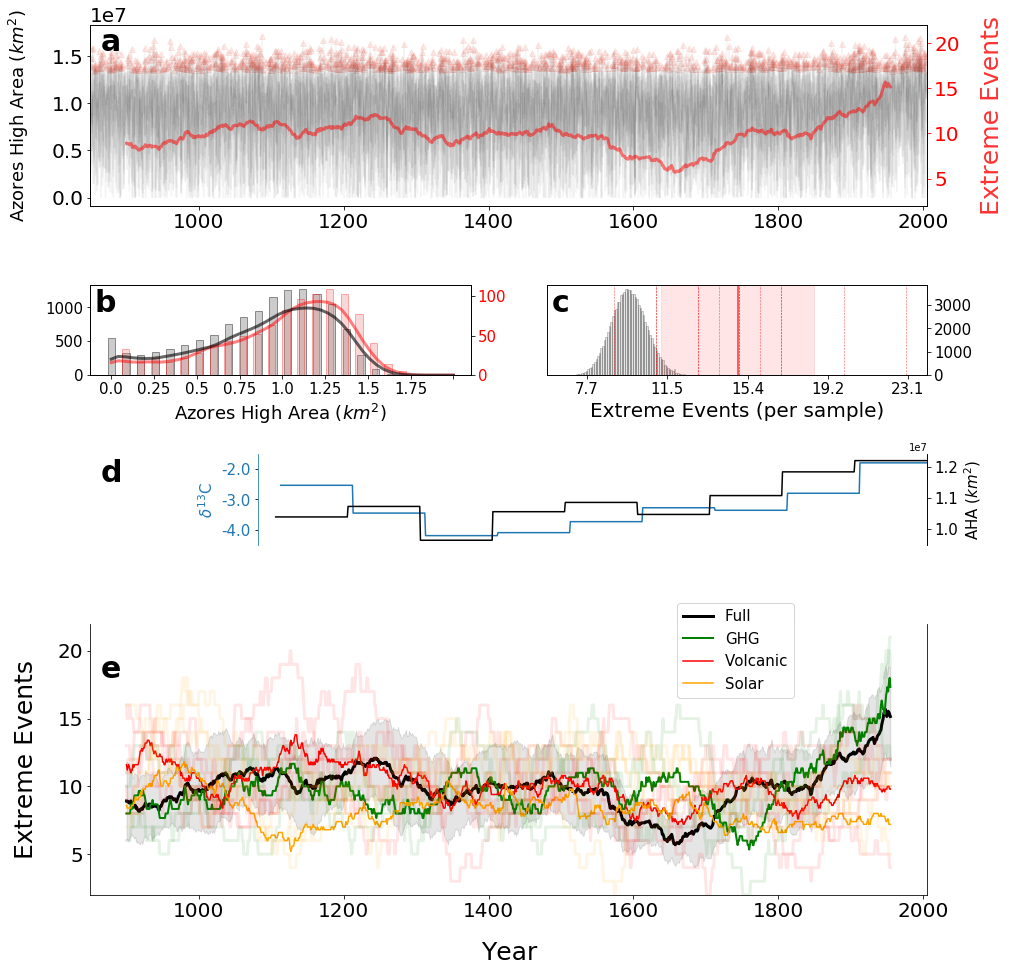

In [17]:
##########################################       SET PARAMETERS      ######################################################

#formatting parameters
fontsize_title        = 25
fontsize_axlabel      = 25
fontsize_ticks1       = 25
fontsize_ticks2       = 15
fontsize_legend       = 15

#special forcings ensemble parameters  
shade_std = False
show_mems = True
shade_std_full = True
show_mems_full = False

#Define figure and grid specifications 
fig = plt.figure(figsize=(15,16))
gs = gridspec.GridSpec(4, 2, height_ratios=[2, 1,1,3])

###########################################################################################################################
#######################################    Extreme AHA Running Bin LME    #################################################
###########################################################################################################################

ax0 = fig.add_subplot(gs[0:2])
add_subplot_index(ax0,'a',y=.86,x=.012)
#calculate and plot background timeseries
for i in range(0,13):
    ax0.plot(np.arange(850,2006),lme_aha[i,:],color='black',alpha=.04);
    highest,where_highest = get_extremes(series=lme_aha[i,:], percent=percent,top=True);
    ax0.scatter(where_highest+850,highest,color='salmon',marker='^',alpha=.15);
    
#plot ensemble mean extreme AHA running bin analysis
ax1=ax0.twinx()
ax1.plot(np.arange(850,2006),running_bin_big.mean(axis=0),color='red',linewidth=3,alpha=.5);

#adjust axes and labels
ax0.set_xlim(850,2006)
ax0.set_xticklabels(ax0.get_xticks().astype(int),fontsize=fontsize_ticks1);
# ax0.set_yticklabels(ax0.get_yticks().astype(int)/1e6,fontsize=fontsize_ticks1,color='black');
ax0.set_ylabel(r'Azores High Area ($km^2$)',fontsize=18,labelpad=20,color='black')
# ax0.set_xlabel(r'Year',fontsize=25,labelpad=20,color='black')
ax1.tick_params(labelsize=20,color='red',labelcolor='red')
ax1.set_ylim(2,22)
ax1.set_ylabel(r'Extreme Events',fontsize=fontsize_ticks1,labelpad=20,color='red',alpha=.8);
ax0.tick_params(labelsize=20)
ax0.yaxis.offsetText.set_fontsize(20)


###########################################################################################################################
###############################     Industrial Era vs past 1000 AHA histograms    #########################################
###########################################################################################################################

#draw distribution curves
def get_kde(data=None,lam = .15):
    density = gaussian_kde(data)
    density.covariance_factor = lambda : lam
    density._compute_covariance()
    return density

###########################################    Preindustrial Histogram   ##################################################

#assign axes preindustrial 
ax2 = plt.subplot(gs[2])
add_subplot_index(ax2,'b',y=.7,x=.012)
#plot histogram preindustrial 
ax2.hist(lme_aha[:,:-156].flatten(),color='grey',alpha=.4,bins=20,edgecolor='black',rwidth=.5,align='left')
#adjust axes and labels preindustrial
ax2.set_yticklabels(ax2.get_yticks().astype(int),fontsize=fontsize_ticks2,color='black')
ax2.set_xticklabels(np.around((ax2.get_xticks().astype(int))/1e7,2),fontsize=fontsize_ticks2)
ax2.set_xlabel(r'Azores High Area ($km^2$)',fontsize=18,color='black',labelpad=5)

#############################################    Industrial Histogram   ###################################################

#assign axes industrial
ax5 = ax2.twinx()
#plot histogram industrial
ax5.hist(lme_aha[:,-156:].flatten(),color='lightcoral',alpha=.3,bins=20,edgecolor='red',rwidth=.5,align='right')
#adjust axes and labels industrial
ax5.set_yticklabels(ax5.get_yticks().astype(int),fontsize=15,color='red')

####################################################   KDE Plots   ########################################################

#assign axes
ax6 = ax2.twinx()
#define x-axis spacing 
xs = np.linspace(0,2)*1e7
#plot KDEs
ax6.plot(xs,get_kde(data=lme_aha[:,-156:].flatten())(xs),color='red',label='1850-2006',linewidth=3,alpha=.5);
ax6.plot(xs,get_kde(data=lme_aha[:,:-156].flatten())(xs),color='black',label='850-1850',linewidth=3,alpha=.6);
#adjust axes and labels
ax6.set_ylim([0,1.5*1e-7])
ax6.set_yticks([]);

#print the result of the Mann-Whitney test


###########################################################################################################################
###########################################      Plot Monte Carlo results     #############################################
###########################################################################################################################

#define x-axis spacing
if preindustrial_threshold:
    if percent_montecarlo == 10:
        xs = np.linspace(75,312,235)
    elif percent_montecarlo == 5:
        xs = np.linspace(36,156,120)
else:
    if percent_montecarlo == 10:
        xs = np.linspace(75,312,235)
    elif percent_montecarlo == 5:
        xs = np.linspace(36,156,120)

##############################################    Monte Carlo Histogram   #################################################

#assign axes
ax3 = plt.subplot(gs[3])
add_subplot_index(ax3,'c',y=.7,x=.012)
#plot histogram
ax3.hist(n_extremes_large,bins=xs,color='grey',alpha=.2,edgecolor='black',label='')

#adjust axes and label
ax3.set_xlim([xs[0],xs[-1]])
ax3.tick_params(labelsize=15)
ax3.yaxis.tick_right()
ax3.set_yticks([0,1000,2000,3000])
ax3.set_xticklabels(np.around(ax3.get_xticks()/13,1),fontsize=fontsize_ticks2);
ax3.set_xlabel('Extreme Events (per sample)',fontsize=20,labelpad=5);
ax3.axvline(Ind_large.sum(),label='Industrial Era',linewidth=2,color='red',alpha=.6)


###################################   Display industrial era through ensemble members #####################################

#assign axes
ax4 = ax3.twiny()
#draw lines for each ensemble member
for i in range(0,13):
    ax4.axvline(Ind_large[i],color='red', linestyle='--',linewidth=.6,alpha=.6)
#draw vertical line where industrial era fits on Monte Carlo KDE
#shade area for +/-1 std from mean of extreme events per ensemble
ax4.axvspan(Ind_large.mean()-Ind_large.std(),Ind_large.mean()+Ind_large.std(),color='red',alpha=.1)
#adjust axes and labels
ax4.set_xlim([xs[0]/13,xs[-1]/13])
ax4.set_xticks([])

###########################################################################################################################
############################################         Plot 100yr bins         ##############################################
###########################################################################################################################

#set up axis
ax6 = plt.subplot(gs[4:6])
add_subplot_index(ax6,'d',y=.70,x=.012)

ax6.plot(AHA_Iso['isotope_time'],AHA_Iso['d13C'],label='d13C');
ax6.set_ylim(-4.5,-1.5);
ax6.set_yticks(np.arange(-4,-1.5,1))
ax6.set_xlim(850,2006)

ax6.yaxis.set_label_coords(.15,.49)
ax6.spines["left"].set_position(("axes", .2))
ax6.spines["left"].set_color("tab:blue")
ax6.spines['bottom'].set_visible(False)
ax6.spines['top'].set_visible(False)
ax6.set_xticks([])
ax6.set_ylabel(r'$\delta^{13}$C',size=15,c='tab:blue')
ax6.set_yticklabels(ax6.get_yticks(),fontsize=15,c='tab:blue')

ax7 = ax6.twinx()       
ax7.plot(AHA_Iso['AHA_time'],AHA_Iso['AHA_mean'],label='AHA',c='k');
ax7.spines['bottom'].set_visible(False)
ax7.spines['top'].set_visible(False)
ax7.spines['left'].set_visible(False)
ax7.set_ylim(.95e7,1.24e7)
ax7.tick_params(labelsize=15)
ax7.set_ylabel(r'AHA ($km^2$)',size=15,c='k')


###########################################################################################################################
############################################      Plot Special Forcings      ##############################################
###########################################################################################################################

#assign axes
ax5 = plt.subplot(gs[6:8])
ax5.spines['top'].set_visible(False)
add_subplot_index(ax5,'e',y=.8,x=.012)

#plot special forcings ensemble mean running bin analyses
ax5.plot(np.arange(850,2006),running_bin_big.mean(axis=0),color='black',label='Full',linewidth=3)
ax5.plot(np.arange(850,2006),running_bin_big_ghg.mean(axis=0),color='green',label='GHG',linewidth=2)
ax5.plot(np.arange(850,2006),running_bin_big_volcanic.mean(axis=0),color='red',label='Volcanic',linewidth=1.5)
ax5.plot(np.arange(850,2006),running_bin_big_solar.mean(axis=0),color='orange',label='Solar',linewidth=1.5)

#customize display of ensemble
if shade_std_full:
    ax5.fill_between(np.arange(850,2006),
                    running_bin_big.mean(axis=0)-running_bin_big.std(axis=0),
                    running_bin_big.mean(axis=0)+running_bin_big.std(axis=0),
                    color='black', alpha=.1)
if shade_std:
    ax5.fill_between(np.arange(850,2006),
                    running_bin_big_ghg.mean(axis=0)-running_bin_big_ghg.std(axis=0),
                    running_bin_big_ghg.mean(axis=0)+running_bin_big_ghg.std(axis=0),
                    color='green', alpha=.1)
    ax5.fill_between(np.arange(850,2006),
                    running_bin_big_volcanic.mean(axis=0)-running_bin_big_volcanic.std(axis=0),
                    running_bin_big_volcanic.mean(axis=0)+running_bin_big_volcanic.std(axis=0),
                    color='red', alpha=.1)
    ax5.fill_between(np.arange(850,2006),
                    running_bin_big_solar.mean(axis=0)-running_bin_big_solar.std(axis=0),
                    running_bin_big_solar.mean(axis=0)+running_bin_big_solar.std(axis=0),
                    color='orange', alpha=.1)
if show_mems_full:
    for i in range(0,13):
        ax5.plot(np.arange(850,2006),running_bin_big[i,:],color='black',linewidth=3,alpha=.15);
if show_mems:
    for i in range(0,3):
        ax5.plot(np.arange(850,2006),running_bin_big_ghg[i,:],color='green',linewidth=3,alpha=.1);
    for i in range(0,5):
        ax5.plot(np.arange(850,2006),running_bin_big_volcanic[i,:],color='red',linewidth=3,alpha=.1);
    for i in range(0,4):
        ax5.plot(np.arange(850,2006),running_bin_big_solar[i,:],color='orange',linewidth=3,alpha=.1);

#adjust axes and labels
ax5.set_xlim(850,2006)
ax5.tick_params(labelsize=20)
ax5.set_ylabel('Extreme Events',fontsize=fontsize_axlabel,labelpad=20);
ax5.set_xlabel('Year',fontsize=fontsize_axlabel,labelpad=20);
ax5.set_ylim(2,22)
# ax5.set_yticklabels(ax5.get_yticks().astype(int))
#Plot legend
box = ax5.get_position()
ax5.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax5.legend(loc=4, bbox_to_anchor=(.85, .7),fontsize=fontsize_legend);


#==========================================================================================================================
#final adjustments to subplot spacing
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=.5)

# plt.savefig('/home/ncresswell/Desktop/AzoresHigh_Nature/figure_files/revised/LMEAzoresHigh_REVISED_8-22-21.png',dpi=120)
# plt.savefig('/home/ncresswell/Desktop/AzoresHigh_Nature/figure_files/revised/LMEAzoresHigh_REVISED_5-07-22.pdf',dpi=360)

Here I'll look at ensemble simulations individually to guage how the externally forced variability compars to internal variability. 

In [2]:
##########################################       SET PARAMETERS      ######################################################
preindustrial_threshold = False
window                  = 101
percent                 = 10#   <-----  DEFINE EXTREME EVENT DEFINITION

###########################################################################################################################
##########################################    AHA in LME running bin   ####################################################
###########################################################################################################################


print('AHA Diagnostic and Running Bin Analysis on CESM-LME ouput. Window is '+
      str(window)+
      '; analyzing largest '+
      str(percent)+
      '% of AHA events.')

threshold_lme = get_threshold(filename='//climodes/data3/datasets/ucar/cesm1-cam5-lme/psl/b.e11.BLMTRC5CN.f19_g16.001.cam.h0.PSL.*.nc',
                              var_name='PSL',
                              open_as_data_array=False,
                              fix_lon=True,
                              calculate_seasonal_average=True,
                              region=dict(lat_min = 10,
                                          lat_max = 52,
                                          lon_min = -60,
                                          lon_max = 10),
                              conversion=.01)

#Loading LME PSL data 
# EnsembleMembers_psl_DJF = np.load('/data/ncresswell/cesm-cam5-lme/EnsembleMembers_DJF_SLP_850-2005.npy')
EnsembleMembers_psl_DJF = np.load('/data/ncresswell/cesm-cam5-lme/DETRENDED-global_EnsembleMembers_DJF_SLP_850-2005.npy')
lat = np.load('/data/ncresswell/cesm-cam5-lme/lat.npy')
lon = np.load('/data/ncresswell/cesm-cam5-lme/lon.npy')

#Calculate AHA and perform running bin analysis
lme_aha = np.empty([13,1156])
running_bin_big   = np.zeros([13,1156])

for i in range(0,13):
    
    psl_djf_AH = filter_lat_lon(data_unfiltered=filter_tresh(data_unfiltered=EnsembleMembers_psl_DJF[i,:,:,:],
                                                             below=True,
                                                             threshold=threshold_lme),
                                lat=lat,lat_range=[10,52],
                                lon=lon,lon_range=[-60,10]);
    lme_aha[i,:] = get_area_of_filtered_data(psl_djf_AH,lat,lon);
    #running bun analysis using previously calculated aha
    running_bin_big[i,:],_  = get_bin_timeseries(index=lme_aha[i,:],percent=percent,window=window);

AHA Diagnostic and Running Bin Analysis on CESM-LME ouput. Window is 101; analyzing largest 10% of AHA events.


For ensemble simulation 1 the 20th century has 21.0 extreme events (91.00346020761245)
For ensemble simulation 2 the 20th century has 15.0 extreme events (88.49480968858131)
For ensemble simulation 3 the 20th century has 16.0 extreme events (91.00346020761245)
For ensemble simulation 4 the 20th century has 15.0 extreme events (89.3598615916955)
For ensemble simulation 5 the 20th century has 18.0 extreme events (91.34948096885813)
For ensemble simulation 6 the 20th century has 13.0 extreme events (71.97231833910035)
For ensemble simulation 7 the 20th century has 11.0 extreme events (62.45674740484429)
For ensemble simulation 8 the 20th century has 15.0 extreme events (90.65743944636678)
For ensemble simulation 9 the 20th century has 11.0 extreme events (72.31833910034602)
For ensemble simulation 10 the 20th century has 13.0 extreme events (74.74048442906575)
For ensemble simulation 11 the 20th century has 17.0 extreme events (91.08996539792388)
For ensemble simulation 12 the 20th centur

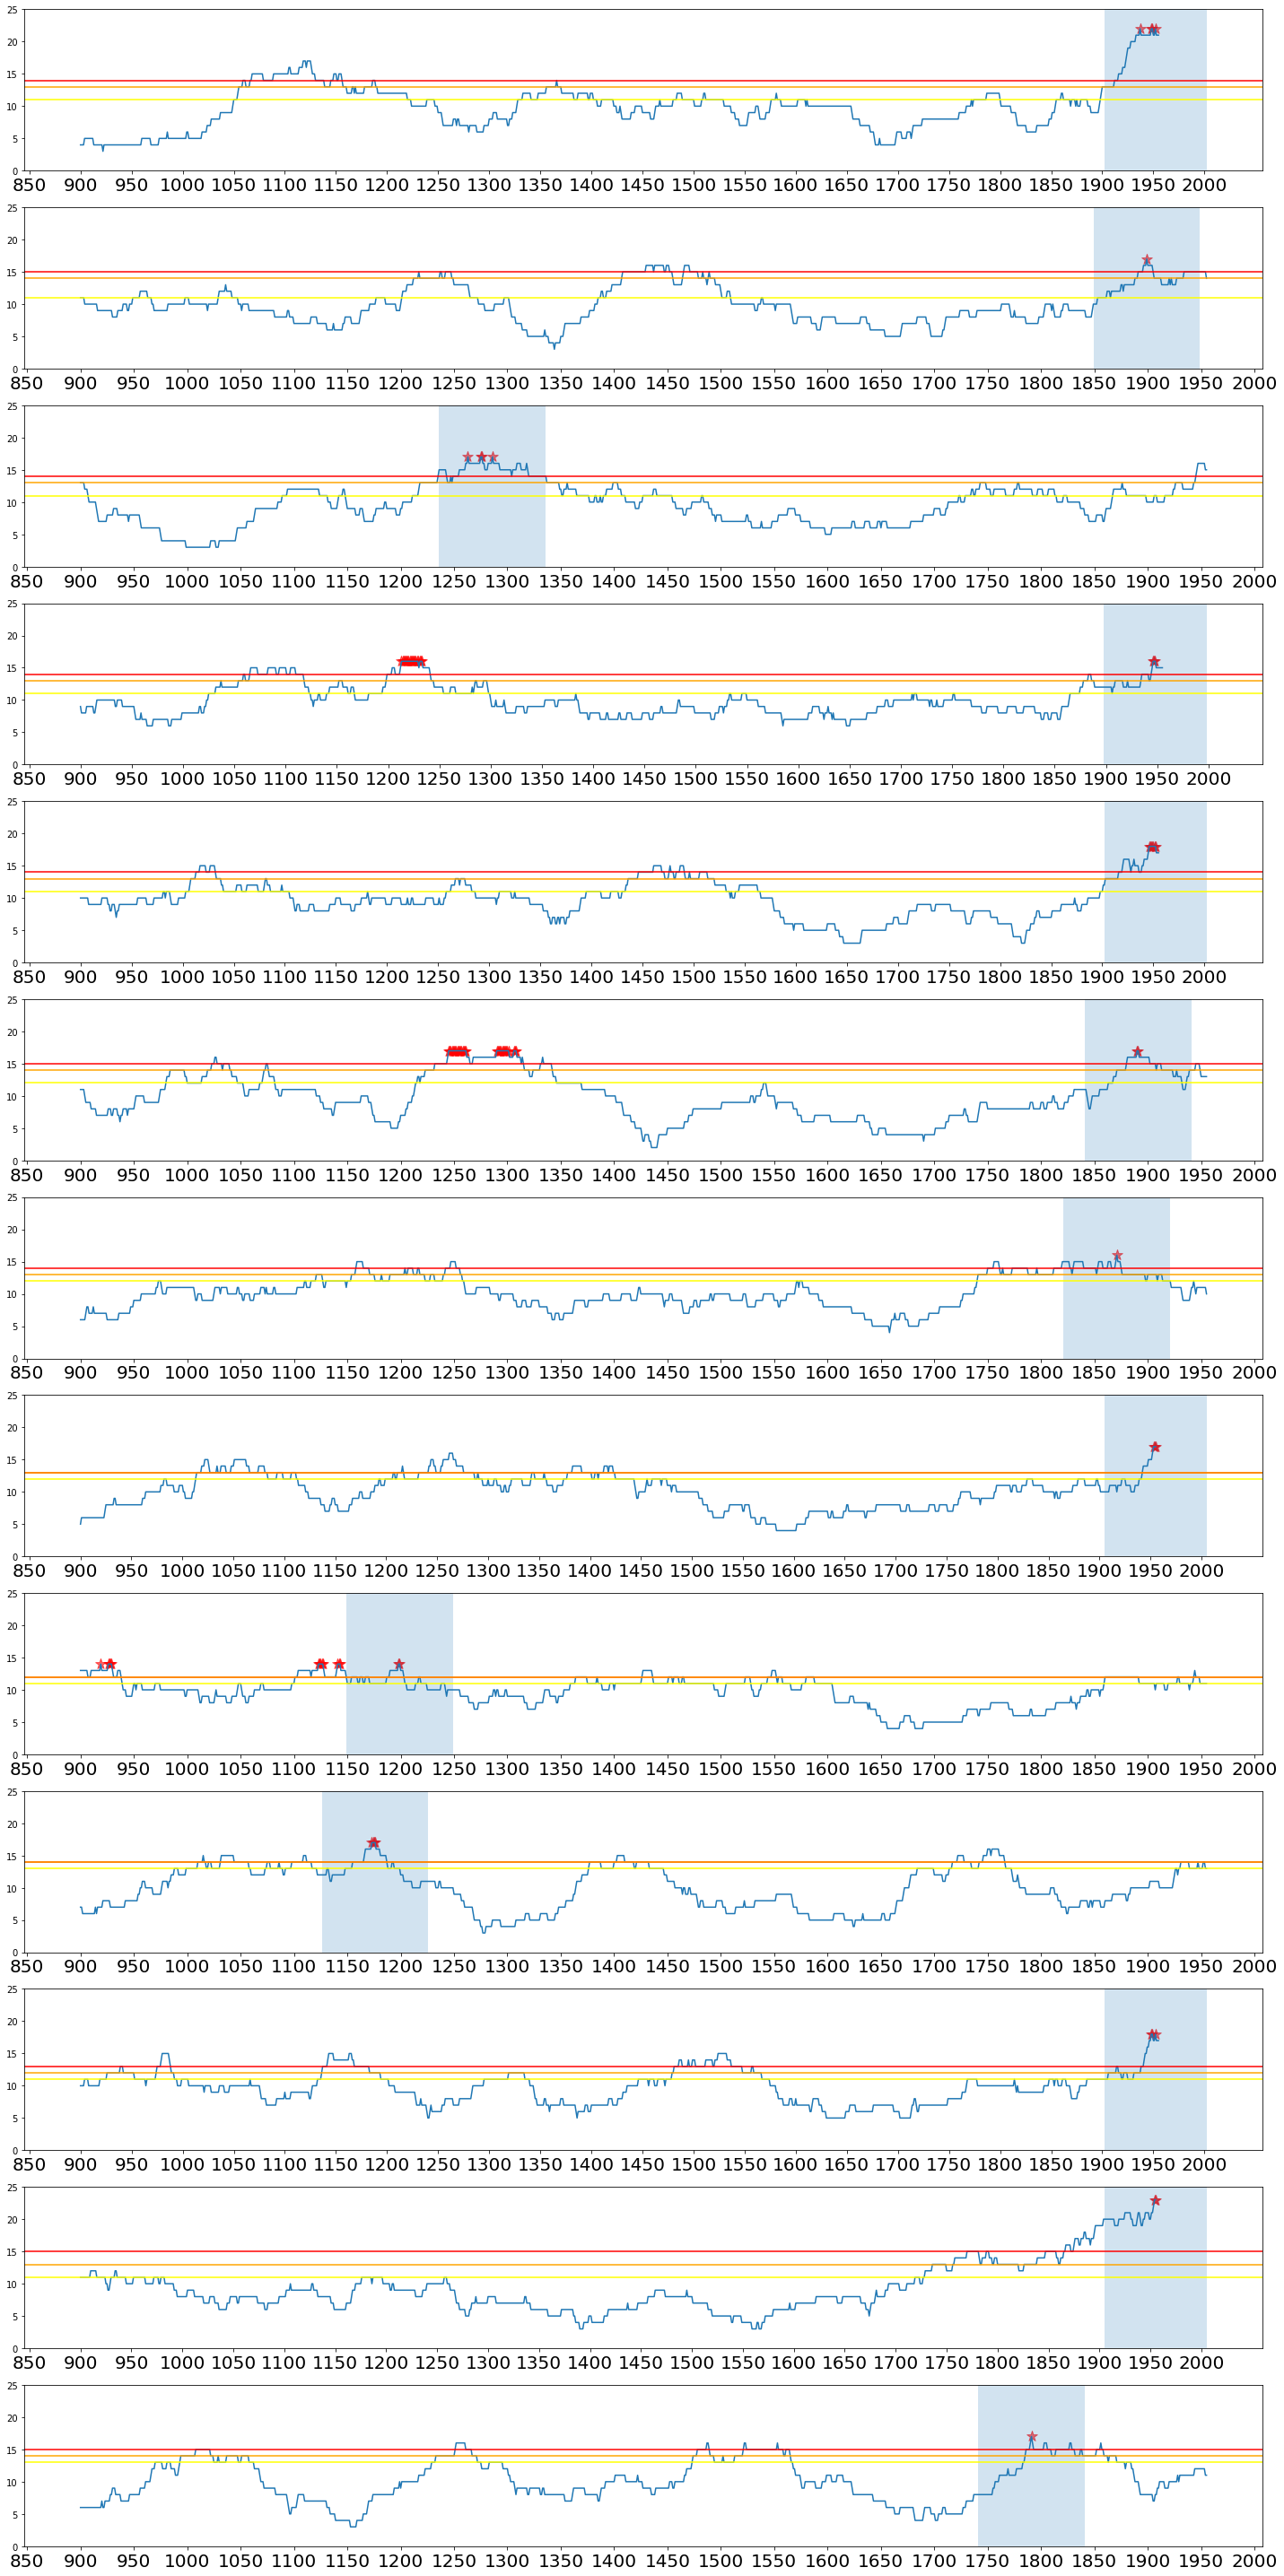

In [3]:
fig = plt.figure(figsize=(20,40))
axs = fig.subplots(nrows=13,ncols=1)

extremes_20c = []

for i in range(0,13):
        
        #plot extreeme event freqeuncy
        axs[i].plot(np.arange(850,2006),running_bin_big[i,:])
        
        #set tick labels
        axs[i].set_xticks(np.arange(850,2006,50))
        axs[i].set_xticklabels(axs[i].get_xticks(),fontsize=20)
        
        #find century with most extreme events make sure keep track of multiplt most extreme centuries
        axs[i].scatter(np.where(running_bin_big[i,:]==np.nanmax(running_bin_big[i,:]))[0]+850,
                       running_bin_big[i,np.where(running_bin_big[i,:]==np.nanmax(running_bin_big[i,:]))[0]],
                       color='red',marker='*',alpha=.6,s=150)
        axs[i].fill_betweenx(np.arange(0,30),
                             np.where(running_bin_big[i,:]==np.nanmax(running_bin_big[i,:]))[0][-1]+800,
                             np.where(running_bin_big[i,:]==np.nanmax(running_bin_big[i,:]))[0][-1]+900,
                             alpha=.2)
        axs[i].set_ylim(0,25)
        
        #indicate percentiles
        axs[i].axhline(np.percentile(running_bin_big[i,50:1106],90),color='red')
        axs[i].axhline(np.percentile(running_bin_big[i,50:1106],85),color='orange')
        axs[i].axhline(np.percentile(running_bin_big[i,50:1106],70),color='yellow')
        
        print('For ensemble simulation '+str(i+1)+
              ' the 20th century has '+
              str(running_bin_big[i,-56])+
              ' extreme events ('+
              str(get_percentile(running_bin_big[i,:],running_bin_big[i,-56]))+')')
        
        extremes_20c.append(running_bin_big[i,-56])
        
fig.tight_layout()

The message here is that the past 200 years have extremely large AH even 

In [5]:
print('the 20th century has seen an ensemble average of '+str(np.mean(extremes_20c))+
      ' the average for all other centuries is: '+ str(np.nanmean(running_bin_big)))

the 20th century has seen an ensemble average of 15.153846153846153 the average for all other centuries is: 9.889423076923077


In [2]:
%run AzoresHighProjectImports.py
%run /home/ncresswell/AzoresHighExpansion/MyFunctions/DataAnalyzing.py
%run /home/ncresswell/AzoresHighExpansion/MyFunctions/DataProcessing.py
%run /home/ncresswell/AzoresHighExpansion/MyFunctions/Plotting.py

def add_subplot_index(ax,index='a',y=.9,x=.02):
    ax.text(x=x,y=y,
            s=index,
            fontsize=30,
            transform=ax.transAxes,fontweight='bold')


#find the percentile of element within a series
def get_percentile(series, element):
    return np.where(series<=element)[0].size/series.size*100

"""
This function will plot frequency of extreme events as reported by ERA-20C pressure data over a defined window 

USAGE: to use pass an index that is defined through time, and specify what the threshold is for extreme event using the
      'percent' perameter. 

"""

def running_bin_extremes(index=None, percent=20, window=11, time=np.arange(1850,2006), label_large = '',label_small = '',title = '',legend_loc=2, index_has_nan=False,ylim=None):

    running_bin_big   = np.zeros(index.shape)
    running_bin_small = np.zeros(index_shape)
    
    running_bin_big, running_bin_small = get_bin_timeseries(index=index, percent=percent, window=window)
        
    fig, ax = plt.subplots(figsize=(20,10))

    ax.plot(time,running_bin_big,color='red',linewidth=3,alpha=2,label=label_large);
    ax.plot(time,running_bin_small,color='blue',linewidth=3,alpha=10,label=label_small);
   
    #Alter Ticks and labels
    ax.set_xticklabels(ax.get_xticks().astype(int),fontsize=20)
    ax.set_yticklabels(ax.get_yticks().astype(int),fontsize=20)
    ax.set_ylabel('Number of Extreme Events',fontsize=25)
    
    ax.legend(fontsize=30,loc=legend_loc);
    ax.set_title(title,fontsize=35);
    
    return fig,ax

"""
This function offers the same functionality of the running_bin_extremes_era data but is altered to account for the CESM_LME
meaning it assumed the first dimension of the data is ensemble member number. 

usage: pass index defined along ensemble member and time. observe the default parameters used in the calculation and
       rendering of the plot and change if desired 
"""

def running_bin_extremes_lme(index=None, percent=20, window=11, label_large = '',label_small = '',title = '',legend_loc=2, index_has_nan=False,ylim=None):

    #initialize containers for running bin diagnostic 
    running_bin_big   = np.zeros(index.shape)
    running_bin_small = np.zeros(index.shape)
    
    #iterate through ensemble members
    for e_mem in range(0,13):

        running_bin_big[e_mem,:],running_bin_small[e_mem,:] = get_bin_timeseries(index=index[e_mem,:], 
                                                                                 percent=percent, window=window)

    fig, ax = plt.subplots(figsize=(20,10))
        
    ax.plot(time,running_bin_big.mean(axis=0),color='red',linewidth=3,alpha=2,label=label_large);
    ax.plot(time,running_bin_small.mean(axis=0),color='blue',linewidth=3,alpha=10,label=label_small);
   
    #Alter Ticks and labels
    ax.set_xticklabels(ax.get_xticks().astype(int),fontsize=20)
    ax.set_yticklabels(ax.get_yticks().astype(int),fontsize=20)
    ax.set_ylabel('Number of Extreme Events',fontsize=25)
    
    ax.legend(fontsize=30,loc=legend_loc);
    ax.set_title(title,fontsize=35);
    
    return fig,ax

def get_bin_timeseries(index=None, percent=20, window=11):
    
    running_bin_big   = np.zeros(index.shape)
    running_bin_small = np.zeros(index.shape)
    
    #get list of extreme years
    _,where_largest  = get_extremes(series=index,percent=percent,top=True)
    _,where_smallest = get_extremes(series=index,percent=percent,bot=True)
    
    running_bin_big,_  = extremes_per_window(date_range=np.arange(0,index.size), \
                                                      dates_of_extremes=where_largest, \
                                                      window=window);
    running_bin_small,_= extremes_per_window(date_range=np.arange(0,index.size), \
                                                      dates_of_extremes=where_smallest, \
                                                      window=window);
    
    return running_bin_big, running_bin_small
"""

This monte carlo test for frequency will help decide whether the frequency of an event in one sample is significantly
    different to other samples 
    
USAGE: This function will use random sampling to determine the liklihood of extreme event frequency.

        if using without consideration of autocorrelation: 
        
            specify the iterations (the more the merrier) with "n_iterations";
            identify the sample size- because the sampling draws from all model runs, multiply the timespan by the 
                number of ensemble members (13);
            the bool array should be a flattened array describing at each timestep, in each ensemble member whether 
                an extreme event occured;
        
        if considering auto correlation:
            
            specify the iterations (the more the merrier) with "n_iterations";
            identify the sample size- this is where consideration of autocorrelation differs from the first method-
                here you just identify the timespan that is to be sampled from each ensemble member;
            bool array is also different when considering autocorelation- calculate extremes independantly for each 
                ensemble member and pass the bool array as an unflattened 13 by 1156 array.           

RETURNS: Given a confidence level, this will return the lower and upper threshold for confidence. The lower threshold 
        is the number of extremes in a given sample that would qualify as significantly low. THe uppwer threshold in 
        is the number of extremes in a given sample that would qualify as significanly high. 
       
"""

def monte_carlo_frequency(n_iterations, sample_size, bool_array, auto=None):
        
    #initialize array to hold the number of events occuring in each sample 
    n_true = np.empty([n_iterations])
    
    if auto == False:
        for i in range(0,n_iterations):

            #sampling 'sample_size' items from bool array, we record the number of time the conditon in question 
            #is satisfied
            n_true[i] = np.where(np.random.choice(bool_array,sample_size,replace=False))[0].size

        return n_true
    
    else: 
        if bool_array.shape[0] != 13:
            print('not viable bool array. please read the "USAGE" section in the function definiton.')
            
        for i in range(0,n_iterations):
            
            n_true_temp = np.empty([13,sample_size])
            
            for j in range(0,13):
                
                start = np.random.choice(np.arange(0,bool_array.shape[1]-sample_size),1)[0]
                
                n_true_temp[j,:] = bool_array[j,start:start+sample_size]
                
            n_true[i]=np.where(n_true_temp.flatten())[0].size
        
        return n_true

    
    
    
def monte_carlo_variance(n_iterations, sample_size, index_array, auto_corr=None):
        
    #initialize array to hold the variance in each sample 
    variance = np.empty([n_iterations])
    
    if auto_corr == False:
        for i in range(0,n_iterations):

            #sampling 'sample_size' items from index array
            variance[i] = np.nanvar(np.random.choice(index_array,sample_size,replace=False))

        return variance
    
    else: 
        if index_array.shape[0] != 13:
            print('not viable bool array. please read the "USAGE" section in the function definiton.')
            
        for i in range(0,n_iterations):
            
            samples_temp = np.empty([13,sample_size])
            
            for j in range(0,13):
                
                start = np.random.choice(np.arange(0,index_array.shape[1]-sample_size),1)[0]
                
                samples_temp[j,:] = index_array[j,start:start+sample_size]
                
            variance[i]=np.nanvar(samples_temp.flatten())
        
        return variance
            
    